# Describing Turbulence Properties

This notebook introduces you to some datasets collected by eddy correlation systems to get a sense of the properties of turbulence.  Typically, these systems feature a sonic anemometer, which can sample the temperature and 3D wind at a high frequency (10 Hz, 20 Hz).  The dataset here comes from the Boulder Atmospheric Observatory (BAO) tower that was recording boundary layer data in Erie, Colorado until Summer 2016.  See: https://psl.noaa.gov/technology/bao/

The BAO tower is about 300 meters tall and is instrumented at several heights (2-m, 5-m, 10-m, 50-m, 100-m, 150-m, 200-m, 250-m, and 300-m).

Let's start off by loading in some important Python packages that can help us sift through this data:

In [10]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Loading in the data:

The dataset that we're going to load in is a netCDF dataset.  This is a really nice data format that stores both information about the dataset and multi-dimensional data in one file.  The library called "Xarray" does a lot of the heavy lifting for us in reading in the file and making the data accessable.  See: https://docs.xarray.dev/en/stable/

In [2]:
data = xr.open_dataset('data/ecor.z01.00.20150405.120000.nc')

In [27]:
data

<xarray.Dataset>
Dimensions:           (time: 43200, sample: 20, sample_10: 10)
Coordinates:
  * time              (time) datetime64[ns] 2015-04-05T00:00:00.500000 ... 20...
Dimensions without coordinates: sample, sample_10
Data variables: (12/88)
    base_time         datetime64[ns] ...
    u_nw_50m          (time, sample) float32 2.138 2.153 2.122 ... -1.295 -1.334
    v_nw_50m          (time, sample) float32 6.0 6.024 6.004 ... -0.568 -0.6009
    w_nw_50m          (time, sample) float32 -0.03324 -0.0778 ... -0.4977
    tc_nw_50m         (time, sample) float32 8.069 8.092 8.097 ... 19.99 19.99
    diagbits_nw_50m   (time, sample) float32 ...
    ...                ...
    RH_2m_ehs         (time) float32 ...
    P_2m_ehs          (time) float32 ...
    U_10m_bao         (time) float32 ...
    V_10m_bao         (time) float32 ...
    U_10m_ehs         (time) float32 ...
    V_10m_ehs         (time) float32 ...
Attributes:
    INSTRUMENTATION_DOI:       http://dx.doi.org/10.5065/D6ZC80XJ
    history:                   Created: 2015-08-03 21:58:30 +0000\n
    NIDAS_version:             7256
    calibration_file_path:     /net/isf/isff/projects/CABL/ISFF/cal_files/QC,...
    dataset:                   hr_qc_geo_tiltcor
    dataset_description:       QC'd high rate, winds in geographic, tilt corr...
    project_config:            /net/isf/isff/projects/CABL/ISFF/config/cabl.x...
    wind3d_horiz_coordinates:  geographic
    file_length_seconds:       43200
    wind3d_horiz_rotation:     1
    wind3d_tilt_correction:    1

Let's load in the 50-meter data from the sonic anemometer there.  We'll load in the times of the dataset (which turned out to be biased by about 12 hours so we add 12 hours to the data to fix it).  We'll also load in the $u$, $v$, $w$, and $T$ values.

In [3]:
time_array = data.u_nw_50m.time + pd.Timedelta('12 hour')
u = data.u_nw_50m.values
v = data.v_nw_50m.values
w = data.w_nw_50m.values
tc = data.tc_nw_50m.values

print("Shape of u:", u.shape)

Shape of u: (43200, 20)


If you take a look at the dimensions of $u$, you'll see that they're 43500x20.  This is because it's a 20 Hz system.  So to plot this data, we'll need to "flatten" the array:

In [4]:
flattened_u = u.flatten()
flattened_v = v.flatten()
flattened_w = w.flatten()
flattened_tc = tc.flatten()

Now let's construct the Pandas DataFrame for our dataset.  Pandas is a really nice package that helps us organize time series datasets like ours (https://pandas.pydata.org):

In [5]:
times = pd.date_range(start=time_array.values[0], end=time_array.values[-1], periods=len(flattened_u))

df = pd.DataFrame(data={'U (m/s)': flattened_u, 
                        'V (m/s)': flattened_v, 
                        'W (m/s)': flattened_w,
                        'Tc (C)': flattened_tc}, index=times)

Let's look at our data real quick.  In Jupyter Notebooks, you can put your DataFrame in a single cell and run it to look at what's in it:

In [6]:
df

,U (m/s),V (m/s),W (m/s),Tc (C)
2015-04-05 12:00:00.500000000,2.137887,5.999910,-0.033241,8.068909
2015-04-05 12:00:00.549998900,2.153499,6.023893,-0.077798,8.092285
2015-04-05 12:00:00.599997800,2.122276,6.004430,-0.098467,8.097321
2015-04-05 12:00:00.649996701,2.095939,5.969677,-0.078208,8.077240
2015-04-05 12:00:00.699995601,2.143356,6.006574,-0.014195,8.067230
...,...,...,...,...
2015-04-05 23:59:59.300004398,-1.222019,-0.497479,-0.525202,20.002716
2015-04-05 23:59:59.350003298,-1.246738,-0.492466,-0.529282,19.995880
2015-04-05 23:59:59.400002199,-1.318154,-0.578477,-0.506550,19.999329
2015-04-05 23:59:59.450001099,-1.295405,-0.568043,-0.502176,19.994171


## Exploring the Data:

Let's start off by looking at the time series.  Pandas makes it really easy to plot your data and view it:

<AxesSubplot:>

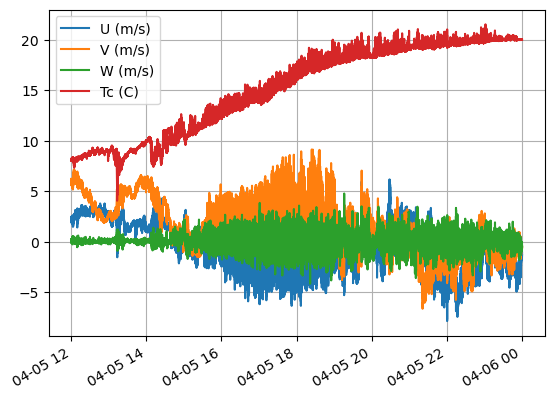

In [7]:
df.plot(grid=True)

That's a really noisy plot, but we kind of see the trends associated with the development of the daytime boundary layer (warming with time).  Pandas allows us to smooth the dataset over time using a rolling average, which can help us see the trends a little better.  You can change the time period over which the averaging is happening if you'd like!

<AxesSubplot:>

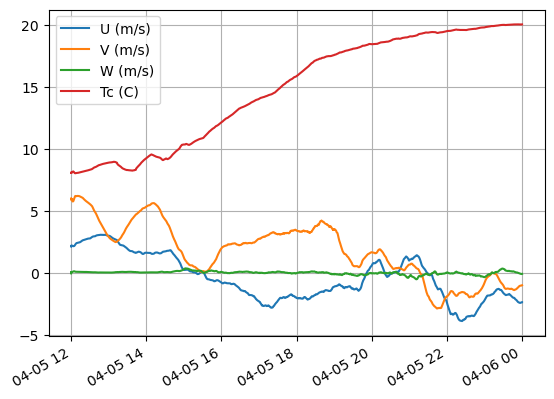

In [8]:
smoothed = df.rolling(window='30 min').mean()
smoothed.plot(grid=True)

The averaging here removes the higher frequency noise in the data.  This can help us see more of the slower changes in the data set.  Now let's look to see how the winds are distributed.  We'll grab just the 30 minutes of the dataset to make things easier.

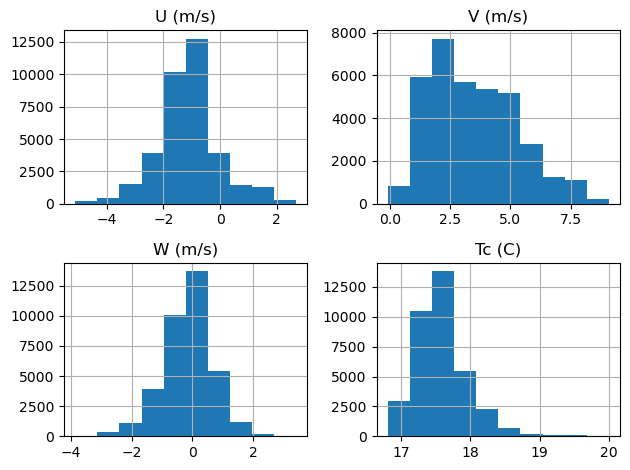

In [12]:
subset = df['2015-04-05 18:30:00':'2015-04-05 19:00:00']
subset.hist()
plt.tight_layout()
plt.show()

## Separating the Mean Flow from the Turbulent Flow

If you look closely at the histograms, much of the data appears to come from a normal distribution.  So we can use Gaussian parameters such as mean and variance to describe the turbulent motions.  For that, we need to take each 30-minute segment of the timeseries and compute a mean.  This 30-minute window is often used in turbulence studies, but other window sizes get used too.

Our goal is to represent the time series in terms of the mean and perturbation parts: $u(t) = \overline{\mbox{u(t)}} + u'(t)$

Let's calculate the 30-minute time averages (because time is our only independent variable):

<AxesSubplot:>

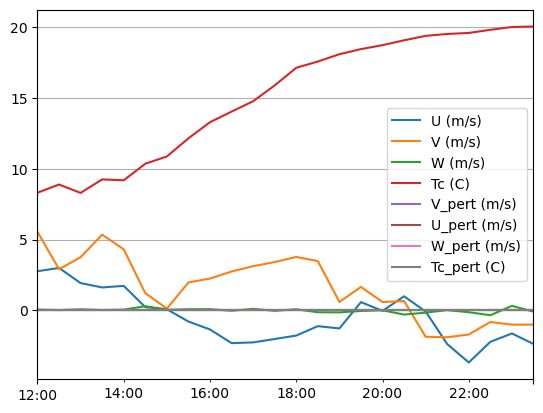

In [55]:
means = df.resample("30T").mean()
means.plot(grid=True)

And now let's calculate the perturbations, and store them in the DataFrame:

In [20]:
df['V_pert (m/s)'] = np.nan
df['U_pert (m/s)'] = np.nan
df['W_pert (m/s)'] = np.nan
df['Tc_pert (C)'] = np.nan

for period, mean in zip(df.resample('30T'), means.iterrows()):
    anomaly = period[1] - mean[1]
    df.loc[period[1].index, 'U_pert (m/s)'] = anomaly['U (m/s)']
    df.loc[period[1].index, 'V_pert (m/s)'] = anomaly['V (m/s)']
    df.loc[period[1].index, 'W_pert (m/s)'] = anomaly['W (m/s)']
    df.loc[period[1].index, 'Tc_pert (C)'] = anomaly['Tc (C)']

The DataFrame should now look different!

In [21]:
df

,U (m/s),V (m/s),W (m/s),Tc (C),V_pert (m/s),U_pert (m/s),W_pert (m/s),Tc_pert (C)
2015-04-05 12:00:00.500000000,2.137887,5.999910,-0.033241,8.068909,0.456614,-0.621515,-0.083651,-0.242636
2015-04-05 12:00:00.549998900,2.153499,6.023893,-0.077798,8.092285,0.480597,-0.605903,-0.128208,-0.219259
2015-04-05 12:00:00.599997800,2.122276,6.004430,-0.098467,8.097321,0.461133,-0.637125,-0.148877,-0.214224
2015-04-05 12:00:00.649996701,2.095939,5.969677,-0.078208,8.077240,0.426381,-0.663463,-0.128618,-0.234304
2015-04-05 12:00:00.699995601,2.143356,6.006574,-0.014195,8.067230,0.463277,-0.616045,-0.064605,-0.244314
...,...,...,...,...,...,...,...,...
2015-04-05 23:59:59.300004398,-1.222019,-0.497479,-0.525202,20.002716,0.514875,1.160318,-0.429852,-0.059534
2015-04-05 23:59:59.350003298,-1.246738,-0.492466,-0.529282,19.995880,0.519887,1.135599,-0.433931,-0.066370
2015-04-05 23:59:59.400002199,-1.318154,-0.578477,-0.506550,19.999329,0.433876,1.064183,-0.411199,-0.062922
2015-04-05 23:59:59.450001099,-1.295405,-0.568043,-0.502176,19.994171,0.444310,1.086932,-0.406825,-0.068079


<AxesSubplot:ylabel='Perturbation'>

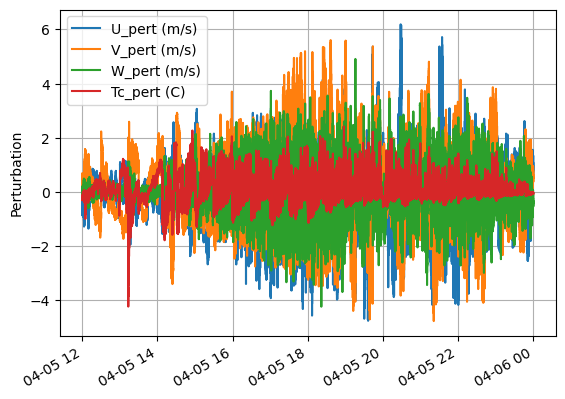

In [23]:
perturbations = df[['U_pert (m/s)', 'V_pert (m/s)', 'W_pert (m/s)', 'Tc_pert (C)']]
perturbations.plot(grid=True, ylabel="Perturbation")

## Calculating statistical properties of turbulence - variance and covariances

Now the have the perturbations of each variables, we can start to compute their variances and covariances.  This way we can describe how the turbulent eddies are interacting with one another:

In [29]:
uu_flux = (perturbations['U_pert (m/s)'] * perturbations['U_pert (m/s)']).resample('30T').mean() # u-variance
uv_flux = (perturbations['U_pert (m/s)'] * perturbations['V_pert (m/s)']).resample('30T').mean()
uw_flux = (perturbations['U_pert (m/s)'] * perturbations['W_pert (m/s)']).resample('30T').mean()

vu_flux = (perturbations['V_pert (m/s)'] * perturbations['U_pert (m/s)']).resample('30T').mean()
vv_flux = (perturbations['V_pert (m/s)'] * perturbations['V_pert (m/s)']).resample('30T').mean() # v-variance
vw_flux = (perturbations['V_pert (m/s)'] * perturbations['W_pert (m/s)']).resample('30T').mean()

wu_flux = (perturbations['W_pert (m/s)'] * perturbations['U_pert (m/s)']).resample('30T').mean()
wv_flux = (perturbations['W_pert (m/s)'] * perturbations['V_pert (m/s)']).resample('30T').mean()
ww_flux = (perturbations['W_pert (m/s)'] * perturbations['W_pert (m/s)']).resample('30T').mean() # w-variance

**Wow!**  That's **a lot** of variables.  And that's only just the start of the fun we'll be having of working with turbulence.

## Descriptor 1: Turbulence Isotropy

Turbulence is said to be isotropic (equal in all directions) if the standard deviations of each of the 3D components of wind are approximately equal to one another.

<AxesSubplot:ylabel='Standard Deviation [m/s]'>

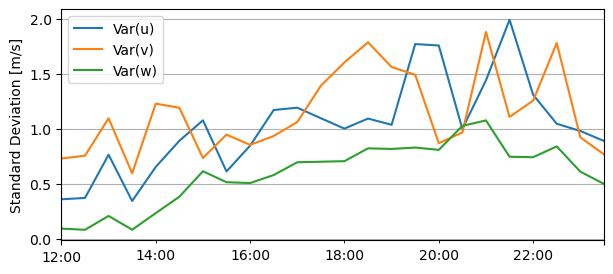

In [53]:
np.sqrt(uu_flux).plot(label='Var(u)', legend=True, figsize=(7,3), grid=True)
np.sqrt(vv_flux).plot(label='Var(v)', legend=True, figsize=(7,3), grid=True)
np.sqrt(ww_flux).plot(label='Var(w)', legend=True, figsize=(7,3), grid=True, ylabel="Standard Deviation [m/s]")

## Descriptor 2: Turbulence Kinetic Energy

Let's calculate a very fundamental variable used to describe turbulence - the turbulence kinetic energy, or **TKE**.

Here's the equation: $e = \frac{1}{2} (u'^{2}+v'^{2}+w'^{2})$

If we average $e$ over time, we can get the mean TKE.

In [30]:
tke = (1./2.) * (uu_flux + vv_flux + ww_flux)

Let's plot TKE over time:

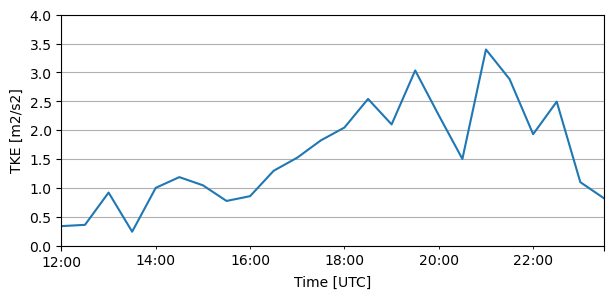

In [32]:
tke.plot(ylim=(0,4), figsize=(7,3), grid='xy', ylabel="TKE [m2/s2]", xlabel="Time [UTC]")
plt.show()

Through the TKE variable, we can see TKE increasing as the day goes on.  As the day goes on, the sun heats the ground.  The ground heats the air nearby and generates *convectively generated eddies*.  These behave like thermal bubbles of warm air rising off the ground that mix within the PBL.  The increase of TKE under a clear sky during the daytime is pretty typical.  You can also see the TKE dropping off in the evening as the thermals no longer have the buoyancy they did when the solar heating was strong.

## Descriptor 3: Turbulent Heat Flux

Speaking of vertical mixing of the air, we can also look at the relationship between temperature and vertical velocity.  We'll also use the Pearson's Correlation Coefficient to see how these two are related:

PearsonRResult(statistic=-0.22652572206420946, pvalue=0.0)
PearsonRResult(statistic=0.08392160939621124, pvalue=2.811948602620044e-57)
PearsonRResult(statistic=-0.06924139461952798, pvalue=1.6723463216621586e-39)
PearsonRResult(statistic=-0.1144681088843705, pvalue=2.8866761136779328e-105)
PearsonRResult(statistic=-0.018057820109870268, pvalue=0.0006116595383677056)
PearsonRResult(statistic=0.09068442402323461, pvalue=1.300032818651798e-66)
PearsonRResult(statistic=0.23991273774003313, pvalue=0.0)
PearsonRResult(statistic=0.1446385332052874, pvalue=1.5571258492069745e-167)
PearsonRResult(statistic=0.4009155108731622, pvalue=0.0)
PearsonRResult(statistic=0.31420352470767277, pvalue=0.0)
PearsonRResult(statistic=0.36228605424494326, pvalue=0.0)
PearsonRResult(statistic=0.44265073996443594, pvalue=0.0)
PearsonRResult(statistic=0.39017224871022654, pvalue=0.0)
PearsonRResult(statistic=0.4096520123243913, pvalue=0.0)
PearsonRResult(statistic=0.38462810713397644, pvalue=0.0)
PearsonRResult(s

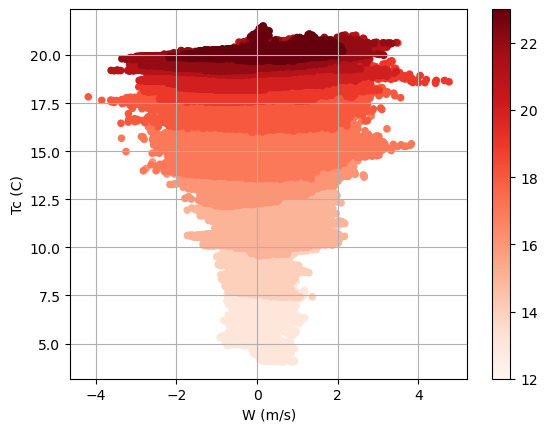

In [34]:
df.plot('W (m/s)', 'Tc (C)', c=perturbations.index.hour, kind='scatter', colorbar=True, grid=True, cmap='Reds')

for period in df.resample('30T'):
    ds1 = df.loc[period[1].index, 'W (m/s)'].dropna()
    ds2 = df.loc[period[1].index, 'Tc (C)'].dropna()
    print(stats.pearsonr(ds1, ds2))

We can compute the turbulent heat flux by calculating the covariance between the temperature observed and the vertical velocities.  We'll also plot it to see how it changes over time:

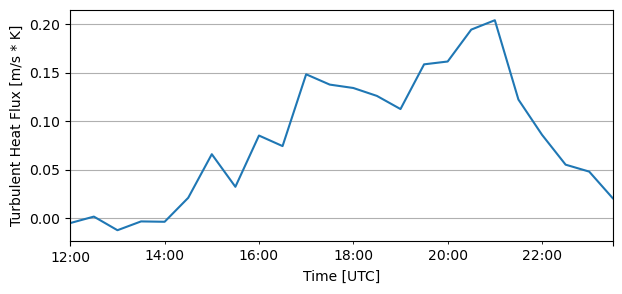

In [65]:
wt_flux = (perturbations['W_pert (m/s)'] * perturbations['Tc_pert (C)']).resample('30T').mean()

wt_flux.plot(ylabel="Turbulent Heat Flux [m/s * K]",  figsize=(7,3), xlabel="Time [UTC]", grid=True)
plt.show()

Again, we see a similar diurnal cycle behavior.  The turbulent heat flux $\overline{\mbox{w'T'}} > 0$ shows heat is being transported upwards from the surface by eddies during the daytime.  As we get closer to the evening, the eddies become less vigorous.

## Descriptor 4: Turbulent Momentum Flux

Turbulent eddies can also mix horizontal momentum upwards and downwards in the PBL:  

<AxesSubplot:xlabel='Time [UTC]'>

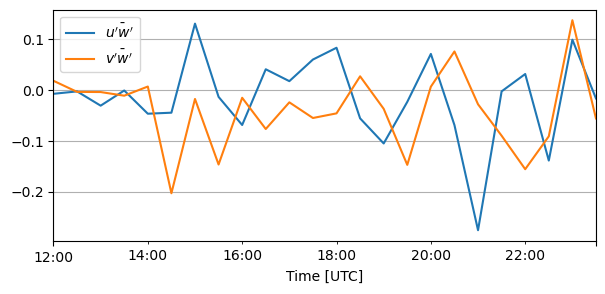

In [64]:
uw_flux.plot(label=r"$\bar{u'w'}$", legend=True, figsize=(7,3), xlabel="Time [UTC]", grid=True)
vw_flux.plot(label=r"$\bar{v'w'}$", legend=True, figsize=(7,3), xlabel="Time [UTC]", grid=True)

## Descriptor 5: Friction Velocity

The structure of the PBL is often one that enables us to use scaling relationships to describe it.  One such scale is called the "friction velocity" or $u_*$.

Air flowing over a surface exerts a stress that transfers momentum to the surface and slows the wind. This parameter is a theoretical wind speed at the Earth's surface that expresses the magnitude of stress. For turbulent flow, the friction velocity is approximately constant in the lowest few metres of the atmosphere. 

This parameter increases with the roughness of the surface. It is used to calculate the way wind changes with height in the lowest levels of the atmosphere.

https://glossary.ametsoc.org/wiki/Friction_velocity

<AxesSubplot:xlabel='Time [UTC]', ylabel='Friction Velocity [m/s]'>

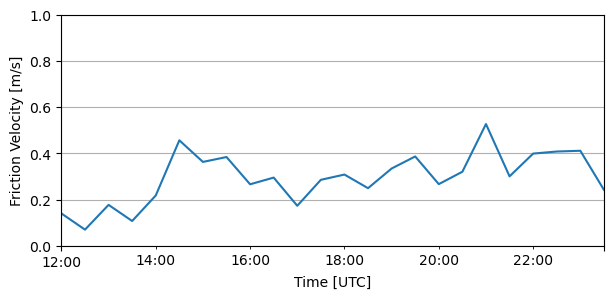

In [66]:
u_star = np.power(np.power(uw_flux,2) + np.power(vw_flux,2), 1./4.)

u_star.plot(ylabel=r"Friction Velocity [m/s]",  figsize=(7,3), ylim=(0,1), xlabel="Time [UTC]", grid=True)